In [1]:
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import expon
import pandas as pd
import numpy as np

In [2]:
from sqlalchemy import create_engine

postgres_str = ('postgresql://localhost/crossvalidated')
cnx = create_engine(postgres_str)

In [21]:
users_df = pd.read_sql_query('''SELECT Posts.Id, Posts.ParentId, Posts.OwnerUserId, Posts.CreationDate as p_creation, b.CreationDate as u_creation FROM Posts LEFT JOIN (SELECT Id, CreationDate FROM Users) b ON Posts.OwnerUserId=b.Id WHERE PostTypeId=2 AND Posts.CreationDate>'2013-07-19 19:14:49.073000000' ''', cnx)
users_df = users_df.dropna(subset=["owneruserid", "u_creation"])

In [22]:
users_df["userage"] = users_df["p_creation"]-users_df["u_creation"]
users_df["userage"] = users_df["userage"].dt.days +  (users_df["userage"].dt.seconds)/(24*60*60) # convert questionage feature


In [24]:
str(users_df["u_creation"].values[0])

'2010-07-19T19:14:49.073000000'

In [23]:
users_df = users_df.rename(columns={"id":"answerid","parentid":"id"} )
users_df.head()

,answerid,id,owneruserid,p_creation,u_creation,userage
0,64883,64877,7290.0,2013-07-19 19:19:46.567,2011-11-09 04:43:15.613,618.608681
1,64885,64880,25.0,2013-07-19 19:40:45.807,2010-07-19 19:09:32.720,1096.021678
2,64886,64521,1191.0,2013-07-19 19:54:09.383,2010-09-03 17:00:30.193,1050.120590
3,64888,64867,14860.0,2013-07-19 20:08:00.133,2012-10-11 13:43:27.957,281.267037
4,64889,64880,22468.0,2013-07-19 20:10:01.830,2013-03-25 00:28:13.523,116.820694


In [24]:
all_questions = pd.read_sql_query('''SELECT * FROM Posts WHERE PostTypeId=1 ''', cnx)
users_df = pd.merge(users_df, all_questions, how="left", on="id")
users_df.head()

,answerid,id,owneruserid_x,p_creation,u_creation,userage,posttypeid,acceptedanswerid,parentid,creationdate,...,lasteditdate,lastactivitydate,title,tags,answercount,commentcount,favoritecount,closeddate,communityowneddate,jsonfield
0,64883,64877,7290.0,2013-07-19 19:19:46.567,2011-11-09 04:43:15.613,618.608681,1,NaN,None,2013-07-19 18:59:14.147,...,2013-07-19 19:06:02.757,2013-07-19 19:19:46.567,Unstandardized beta with an E in it,<notation><arithmetic>,1,2,NaN,NaT,NaT,None
1,64885,64880,25.0,2013-07-19 19:40:45.807,2010-07-19 19:09:32.720,1096.021678,1,65034.0,None,2013-07-19 19:10:11.247,...,2015-10-19 18:05:11.643,2018-05-08 10:31:23.243,Plotting confidence interval bars from summary...,<confidence-interval><data-visualization><desc...,7,7,3.0,NaT,NaT,None
2,64886,64521,1191.0,2013-07-19 19:54:09.383,2010-09-03 17:00:30.193,1050.120590,1,NaN,None,2013-07-16 21:05:07.643,...,NaT,2016-08-17 08:11:03.890,Plotting functions of three variables,<data-visualization>,3,2,NaN,NaT,NaT,None
3,64888,64867,14860.0,2013-07-19 20:08:00.133,2012-10-11 13:43:27.957,281.267037,1,NaN,None,2013-07-19 17:39:20.853,...,2013-07-19 18:02:49.863,2013-08-19 00:07:49.587,How to perform a regression on 5 years of annu...,<regression><eviews>,1,1,0.0,2013-08-19 11:01:12.097,NaT,None
4,64889,64880,22468.0,2013-07-19 20:10:01.830,2013-03-25 00:28:13.523,116.820694,1,65034.0,None,2013-07-19 19:10:11.247,...,2015-10-19 18:05:11.643,2018-05-08 10:31:23.243,Plotting confidence interval bars from summary...,<confidence-interval><data-visualization><desc...,7,7,3.0,NaT,NaT,None


In [25]:
users_df["acceptedanswerid"] = np.absolute((pd.isnull(users_df["acceptedanswerid"])-1).astype(int))
users_df["num_words"] = users_df['body'].str.count(' ') + 1
users_df["num_hyperlinks"] = users_df['body'].str.count('href')

In [35]:
young_questions = (users_df[users_df["userage"]<10])
old_questions = users_df[users_df["userage"]>100]

In [36]:
young_questions.head(100)

,answerid,id,owneruserid_x,p_creation,u_creation,userage,posttypeid,acceptedanswerid,parentid,creationdate,...,title,tags,answercount,commentcount,favoritecount,closeddate,communityowneddate,jsonfield,num_words,num_hyperlinks
5,64890,64861,28236.0,2013-07-19 20:27:19.830,2013-07-19 20:26:42.407,0.000428,1,0,None,2013-07-19 16:52:00.257,...,Sum up uncertainty from confidence intervals in R,<r><regression><confidence-interval><generaliz...,2,1,1.0,NaT,NaT,None,214,0
7,64899,33352,28238.0,2013-07-19 22:04:18.160,2013-07-19 22:04:18.160,0.000000,1,1,None,2012-07-30 17:38:23.620,...,95% confidence ellipse of Lenth's maximum like...,<maximum-likelihood><spatial><gis>,3,2,NaN,NaT,NaT,None,467,2
25,64951,64105,28257.0,2013-07-20 12:27:58.950,2013-07-20 12:27:24.307,0.000394,1,0,None,2013-07-12 00:46:16.690,...,Fitting copulas with a given covariance matrix,<r><probability><copula>,1,0,NaN,NaT,NaT,None,69,0
30,64979,64932,28217.0,2013-07-20 22:12:44.947,2013-07-19 14:22:12.897,1.326759,1,0,None,2013-07-20 07:18:15.327,...,Highly significant positive binary IV: Interac...,<statistical-significance><interaction><binary...,2,0,NaN,NaT,NaT,None,95,0
38,65034,64880,28288.0,2013-07-21 17:32:24.603,2013-07-21 15:34:45.770,0.081690,1,1,None,2013-07-19 19:10:11.247,...,Plotting confidence interval bars from summary...,<confidence-interval><data-visualization><desc...,7,7,3.0,NaT,NaT,None,82,0
74,65197,65193,28343.0,2013-07-23 00:44:51.333,2013-07-23 00:44:51.333,0.000000,1,0,None,2013-07-22 23:30:29.837,...,Why is ARMA used to model a stationary process?,<time-series><stochastic-processes>,3,0,NaN,NaT,NaT,None,96,0
75,65199,65192,28343.0,2013-07-23 01:55:11.290,2013-07-23 00:44:51.333,0.048831,1,0,None,2013-07-22 23:20:25.187,...,How can I get an R-squared value of 1 (fit 100%)?,<regression><variance><excel>,2,7,NaN,NaT,NaT,None,38,0
102,65332,65214,28387.0,2013-07-23 20:50:14.137,2013-07-23 20:49:27.680,0.000532,1,0,None,2013-07-23 07:23:56.680,...,Regression with neural network,<regression><multiple-regression><neural-netwo...,2,2,2.0,NaT,NaT,None,407,0
157,65567,65563,28236.0,2013-07-25 14:13:38.230,2013-07-19 20:26:42.407,5.740914,1,1,None,2013-07-25 13:53:48.260,...,Choosing the number of clusters when only the ...,<clustering><multilevel-analysis><self-organiz...,2,2,NaN,NaT,NaT,None,83,0
172,65649,16207,28494.0,2013-07-26 12:23:19.117,2013-07-26 12:23:19.117,0.000000,1,1,None,2009-04-12 07:24:17.007,...,Correcting for outliers in a running average,<outliers><average><cooks-distance>,7,6,1.0,NaT,NaT,None,418,0


In [38]:
from scipy import stats

In [51]:
for col in young_questions.columns:
    try:
        y = young_questions[col].values
        y = y[~np.isnan(y)]
        o = old_questions[col].values
        o = o[~np.isnan(o)]
        print(col, np.mean(y), np.mean(o))
        # If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
        ks_val = stats.ks_2samp(y[:1000], o[:1000])
        print("ks p value (if high, then same distribution)", ks_val[1], "\n")
    except ValueError:
        pass
    except TypeError:
        pass

answerid 232179.4355980184 248398.86823448827
ks p value (if high, then same distribution) 0.0 

id 189794.7101910828 232037.76096809178
ks p value (if high, then same distribution) 3.2267965488408708e-195 

owneruserid_x 131233.95647558387 52514.01046863406
ks p value (if high, then same distribution) 0.0 

userage 0.8574317080482817 1112.285945090172
ks p value (if high, then same distribution) 0.0 

posttypeid 1.0 1.0
ks p value (if high, then same distribution) 1.0 

acceptedanswerid 0.4280254777070064 0.4971630800844797
ks p value (if high, then same distribution) 0.00677255239123794 

score 8.16751592356688 5.173605799417775
ks p value (if high, then same distribution) 0.001129793859041115 

viewcount 7266.491790516631 3027.4131286032307
ks p value (if high, then same distribution) 0.15955408974378718 

owneruserid_y 83618.69865078226 99108.2010664631
ks p value (if high, then same distribution) 1.3988852814828942e-104 

lasteditoruserid 51037.30058584948 56605.33194046836
ks p v

## Topic analysis

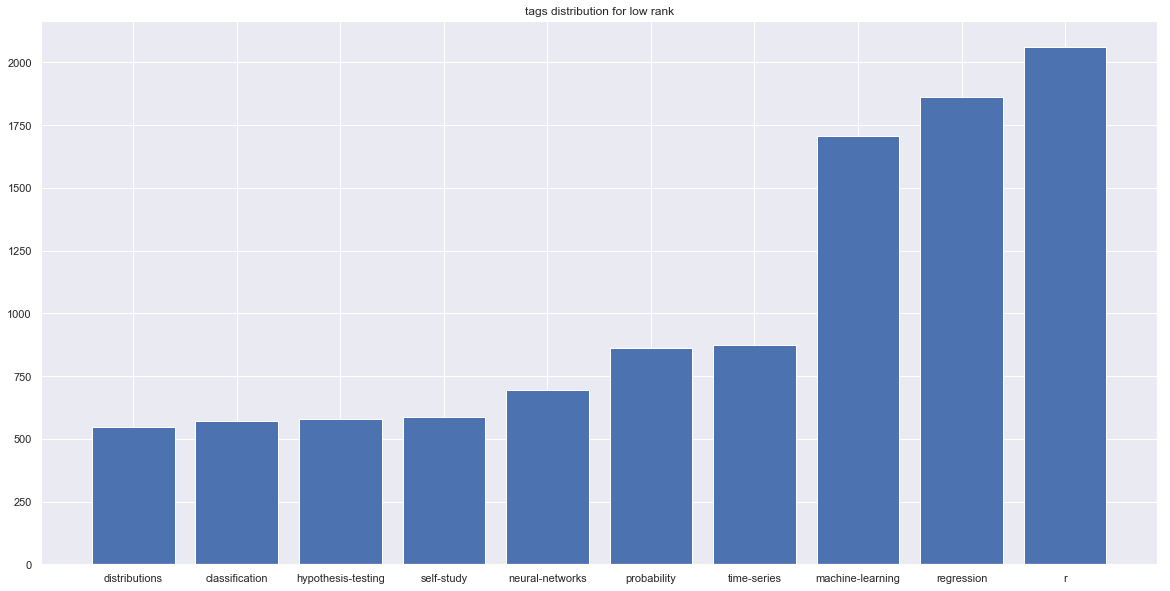

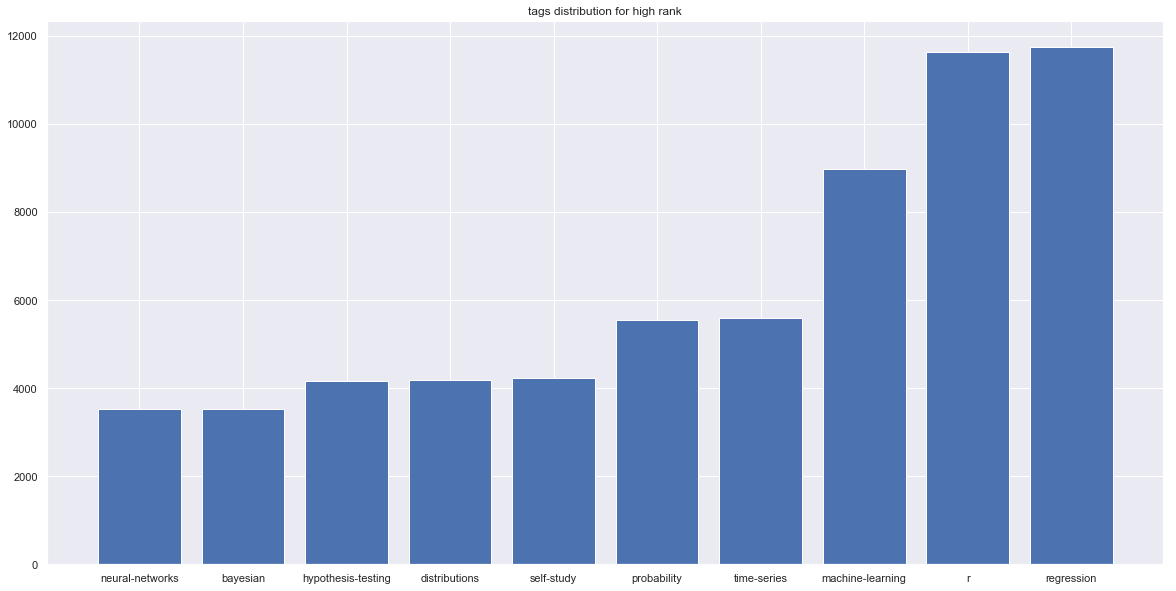

In [52]:
def to_tuple(df, col):
    return tuple(df[col].dropna().values.astype(int).tolist())

def clean_tags(tags):
    tags_clean = []
    for t in tags:
        new_list = t.split("><")
        new = [n.replace("<","").replace(">", "") for n in new_list]
        tags_clean.extend(new)
    return tags_clean

def get_tags(questions, cutoff=6):
    tags = questions["tags"].values
    tags_clean = clean_tags(tags)
    n, c = np.unique(tags_clean, return_counts=True)
    return n[c>=cutoff]

def get_most_tags(vals, num=10):
    tags = vals["tags"].values
    tags_clean = clean_tags(tags)
    uni, c = np.unique(tags_clean, return_counts=True)
    inds = np.argsort(c)
    most_often = uni[inds[-num:]]
    most_often_c = c[inds[-num:]]
    return most_often, most_often_c

def plot_tags(tags_often, counts, title):
    inds = np.arange(len(counts))
    plt.figure(figsize=(20,10))
    plt.bar(inds, counts)
    plt.xticks(inds, tags_often)
    plt.title(title)
    plt.show()

def compare_tags(vals_1, vals_2):
    tags_often, counts_often = get_most_tags(vals_1)
    plot_tags(tags_often, counts_often, "tags distribution for low rank")
    tags_hardly, counts_hardly = get_most_tags(vals_2)
    plot_tags(tags_hardly, counts_hardly, "tags distribution for high rank")
    
        
compare_tags(young_questions, old_questions)

In [64]:
len(young_questions)

14130

### Which tags are occuring in questions chosen by young users vs the ones by old users

In [69]:
tags_young = get_tags(young_questions, cutoff=14)
tags_old = get_tags(old_questions, cutoff = 50)
print("Tags that are in young questions but not in old ones:")
for t in tags_young:
    if t not in tags_old:
        print(t)

Tags that are in young questions but not in old ones:
dispersion
genetics
java
marketing
mlogit
quality-control
variability


### How many tags on average?

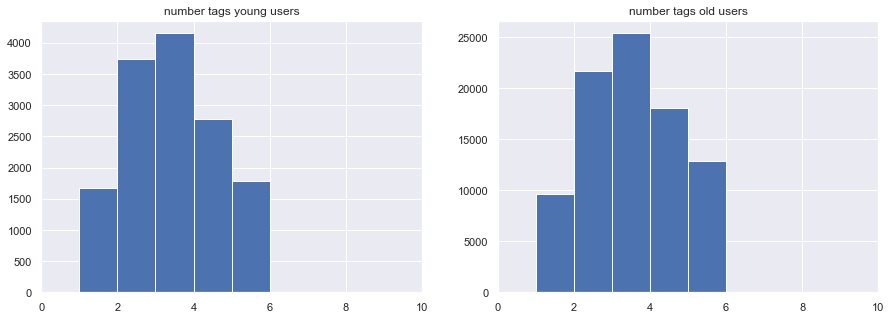

In [88]:
count_list_young = [t.count("<") for t in young_questions["tags"].values]
count_list_old = [t.count("<") for t in old_questions["tags"].values]

len_bins = 10
width_bins=1
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(count_list_young, bins=np.arange(0,len_bins,width_bins))
plt.xlim(0,len_bins)
plt.title("number tags young users")
plt.subplot(1,2,2)
plt.hist(count_list_old, bins=np.arange(0,len_bins,width_bins))
plt.xlim(0,len_bins)
plt.title("number tags old users")
plt.show()

## Erkentnisse:

* higher score, less accepted answer ids (0.006), higher answercount(0.04) --> simply the more popular questions?

## plot distributions

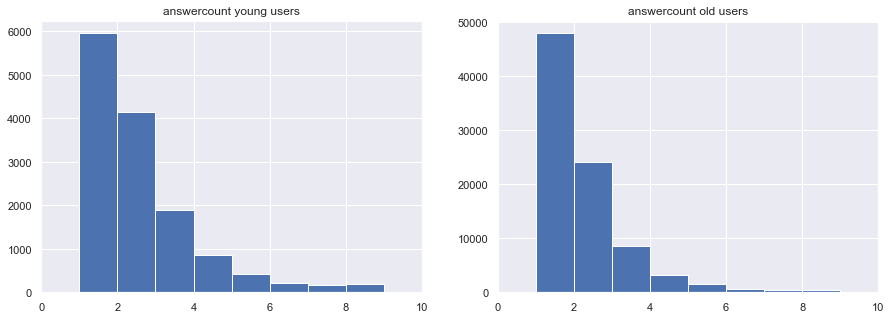

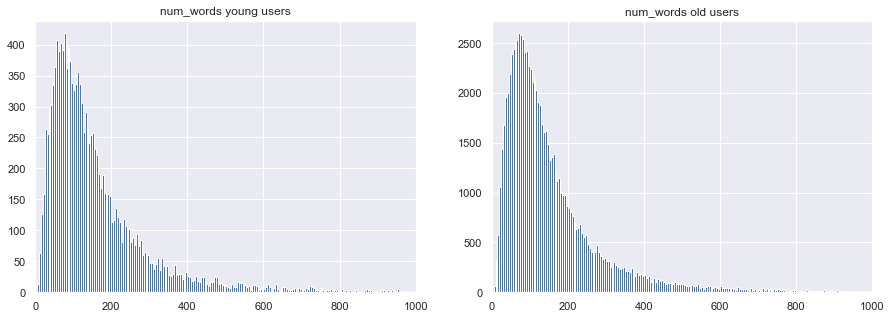

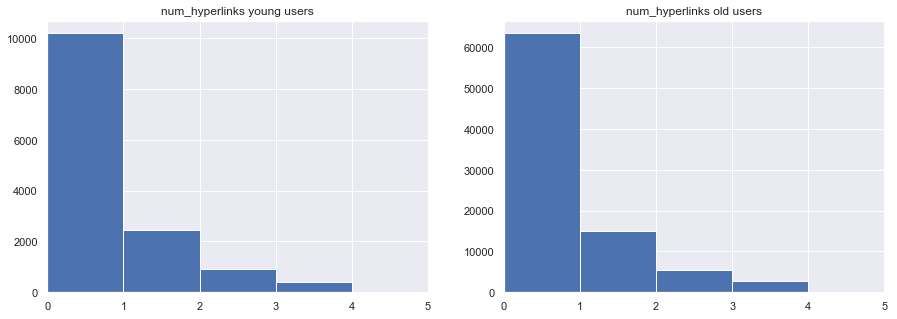

In [84]:
def plot_hists(young_questions, old_questions, col, len_bins, width_bins):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.hist(young_questions[col].values, bins=np.arange(0,len_bins,width_bins))
    plt.xlim(0,len_bins)
    plt.title(col+" young users")
    plt.subplot(1,2,2)
    plt.hist(old_questions[col].values, bins=np.arange(0,len_bins,width_bins))
    plt.xlim(0,len_bins)
    plt.title(col+" old users")
    plt.show()
    
plot_hists(young_questions, old_questions, "answercount", 10, 1)
plot_hists(young_questions, old_questions, "num_words", 1000, 5)
plot_hists(young_questions, old_questions, "num_hyperlinks", 5, 1)



### Hypothesis: New users prefer questions that have already been answered

In [106]:
old_questions.head()

,answerid,id,owneruserid_x,p_creation,u_creation,userage,posttypeid,acceptedanswerid,parentid,creationdate,...,title,tags,answercount,commentcount,favoritecount,closeddate,communityowneddate,jsonfield,num_words,num_hyperlinks
0,64883,64877,7290.0,2013-07-19 19:19:46.567,2011-11-09 04:43:15.613,618.608681,1,0,None,2013-07-19 18:59:14.147,...,Unstandardized beta with an E in it,<notation><arithmetic>,1,2,NaN,NaT,NaT,None,18,0
1,64885,64880,25.0,2013-07-19 19:40:45.807,2010-07-19 19:09:32.720,1096.021678,1,1,None,2013-07-19 19:10:11.247,...,Plotting confidence interval bars from summary...,<confidence-interval><data-visualization><desc...,7,7,3.0,NaT,NaT,None,82,0
2,64886,64521,1191.0,2013-07-19 19:54:09.383,2010-09-03 17:00:30.193,1050.120590,1,0,None,2013-07-16 21:05:07.643,...,Plotting functions of three variables,<data-visualization>,3,2,NaN,NaT,NaT,None,118,0
3,64888,64867,14860.0,2013-07-19 20:08:00.133,2012-10-11 13:43:27.957,281.267037,1,0,None,2013-07-19 17:39:20.853,...,How to perform a regression on 5 years of annu...,<regression><eviews>,1,1,0.0,2013-08-19 11:01:12.097,NaT,None,95,0
4,64889,64880,22468.0,2013-07-19 20:10:01.830,2013-03-25 00:28:13.523,116.820694,1,1,None,2013-07-19 19:10:11.247,...,Plotting confidence interval bars from summary...,<confidence-interval><data-visualization><desc...,7,7,3.0,NaT,NaT,None,82,0


In [117]:
def ans_before(df, cnx):
    count=0
    ans_before = []
    for index, row in df.iterrows():
        # select answers from before this answer
        other_answers = pd.read_sql_query('''SELECT count(Id) FROM Posts WHERE PostTypeId=2 AND ParentId={} AND CreationDate<'{}' '''.format(row["id"], row["p_creation"]), cnx)
        # print(other_answers.values[0,0]) # , ParentId, OwnerUserId, CreationDate as p_creation
        # print("---------------")
        # print(other_answers.head())
        # print("answer count insgesamt:", row["answercount"])
        # count+=1
        # if count>10:
        #     break
        ans_before.append(other_answers.values[0,0])
    return ans_before
    

In [118]:
ans_before_young = ans_before(young_questions, cnx)
ans_before_old = ans_before(old_questions, cnx)

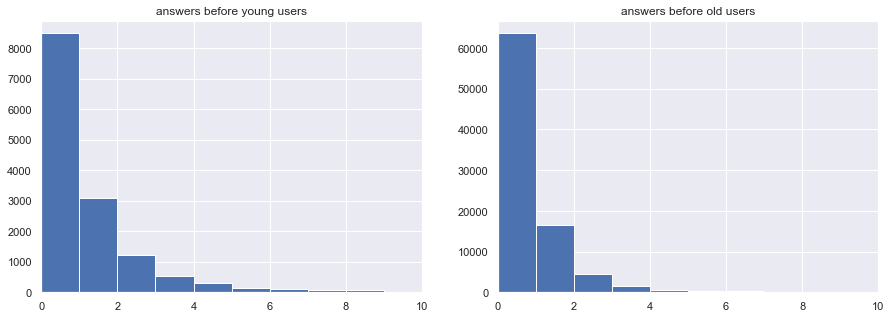

In [119]:
len_bins = 10
width_bins=1
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ans_before_young, bins=np.arange(0,len_bins,width_bins))
plt.xlim(0,len_bins)
plt.title("answers before young users")
plt.subplot(1,2,2)
plt.hist(ans_before_old, bins=np.arange(0,len_bins,width_bins))
plt.xlim(0,len_bins)
plt.title("answers before old users")
plt.show()

In [124]:
print("compare means: Mean young users:", np.mean(ans_before_young), " Mean old users:", np.mean(ans_before_old))
ks_val = stats.ks_2samp(ans_before_young, ans_before_old)
print("ks test p value (if high, then same distribution)", ks_val[1], "\n")

compare means: Mean young users: 0.9617126680820949  Mean old users: 0.5283520748901193
ks test p value (if high, then same distribution) 1.1389106196854247e-166 



### --> significant difference in distribution! 